# Flight Delay Decision Tree and Random Forest
This Script fits decision tree and random forest models to US Flight Data.
Afterward, a real life example of a friend's flights (one past one upcoming) are inputed to examine the predicted outcome.
original Dataset downloaded from Kaggle ( https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023 ). Data has been cleaned and wrangled in previous script.

The outcome is flight delay (minimum 15 minutes, binary coded).
The data includes a sample of flight data from 2019 and 2022. 2020 and 2021 data were excluded due to severe impace of Covid lockdowns, 2023 due to incomplete data

## Table of Contents
1. Import Libraries
2. Import Data
3. Prep Data for models
4. Decision Tree Model
5. Random Forest
6. Inputting Marc's flight

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

import seaborn as sns
import matplotlib.pyplot as plt


# 2. Import Data

In [2]:
# Creating shortcut to folder
path = r'C:\Users\seank\OneDrive\Dokumente\Career Foundry Data Analytics Course\Data Immersion\6'


In [3]:
# Loading Data
data_all = pd.read_pickle(os.path.join(path, 'Data', 'flights_checked.csv'))
data_all.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,Year,Hour_planned_dep,time_bin,delay15,delay30,delay60,delay_type,Origin_State_Code,Destination_State_Code,flight_length
0,2019-01-09,United,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,2019,11,09:00–13:00,0.0,0.0,0.0,On-time(<15m),FL,NJ,Medium Distance(1000-2000)
1,2022-11-19,Delta,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,2022,21,21:00–01:00,0.0,0.0,0.0,On-time(<15m),MN,WA,Medium Distance(1000-2000)
2,2022-07-22,United,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,2022,9,09:00–13:00,0.0,0.0,0.0,On-time(<15m),CO,MN,Short Distance(<1000)
3,2023-03-06,Delta,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,2023,16,13:00–17:00,1.0,0.0,0.0,Short_delay(<1h),MN,CA,Medium Distance(1000-2000)
4,2020-02-23,Spirit,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,2020,18,17:00–21:00,0.0,0.0,0.0,On-time(<15m),FL,TX,Short Distance(<1000)


In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999998 entries, 0 to 2999999
Data columns (total 45 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   object        
 7   ORIGIN_CITY              object        
 8   DEST                     object        
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             int64         
 11  DEP_TIME                 float64       
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             int64  

# 3. Prep Data for Models

In [5]:
data_all[['DIVERTED', 'CANCELLED']].value_counts()

DIVERTED  CANCELLED
0.0       0.0          2913802
          1.0            79140
1.0       0.0             7056
Name: count, dtype: int64

In [6]:
# Dropping diverted and cancelled flights, since we don't want these misinterpreted as being 'not delayed'. They deserve a separate analysis
df = data_all[(data_all['CANCELLED'] != 1) & (data_all['DIVERTED'] != 1)].copy()

In [7]:
df.shape

(2913802, 45)

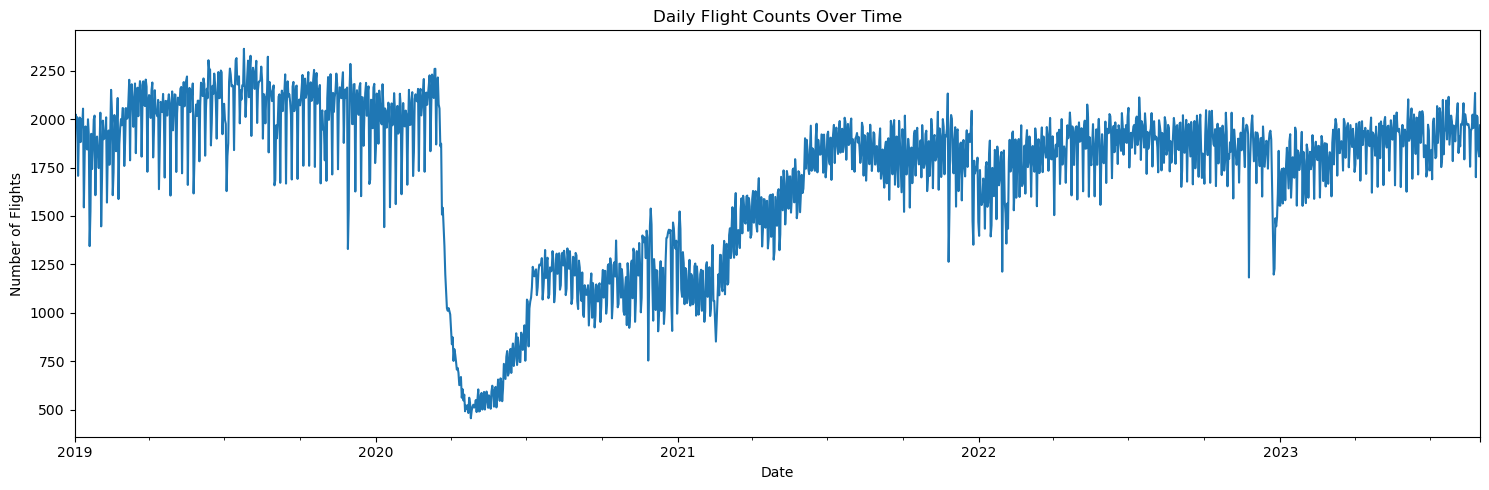

In [8]:
# Looking at flight frequency pre, during and post covid
    # Creating df with daily flight counts
daily_counts = df.groupby('FL_DATE').size() 

# Plot
plt.figure(figsize=(15, 5))
daily_counts.plot()
plt.title('Daily Flight Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()

In [9]:
# Reducing sample to 2019 and 2022 since they're the two full years not so biased by Covid pandemic.
    # 2023 excluded since september-december missing
df = df[df['Year'].isin([2019, 2022])].copy()

In [10]:
# Only keeping relevant cols that don't duplicate information from others.
       # Excluding taxi times since they're more a component of delays than external causes
df = df[['AIRLINE', 'ORIGIN', 'DEST', 'Month', 'Day_of_week',
       'Year', 'time_bin', 'delay15', 'flight_length']].copy()

Looking at sizes of top airports' flights

In [11]:
df['ORIGIN'].value_counts().head(30)

ORIGIN
ATL    71737
ORD    59161
DFW    57630
DEN    52026
CLT    42379
LAX    41587
LAS    33985
PHX    33929
LGA    33440
SEA    31887
IAH    30532
SFO    30421
DTW    28754
MCO    28750
MSP    28433
BOS    28403
DCA    27747
JFK    26228
EWR    26162
SLC    22715
PHL    20480
MIA    19575
BWI    19044
FLL    18119
SAN    18021
BNA    16890
MDW    16011
AUS    15642
TPA    14756
DAL    13811
Name: count, dtype: int64

In [12]:
df['DEST'].value_counts().head(30)

DEST
ATL    71898
ORD    59403
DFW    57207
DEN    51879
CLT    42707
LAX    41452
PHX    34592
LAS    34102
LGA    33100
SEA    31799
IAH    30296
SFO    30186
DTW    28891
MCO    28547
BOS    28318
MSP    28289
DCA    27817
JFK    25935
EWR    25853
SLC    22656
PHL    20382
MIA    19605
BWI    19036
FLL    18129
SAN    18031
BNA    17021
AUS    15797
MDW    15673
TPA    14882
DAL    13682
Name: count, dtype: int64

In [13]:
# New vars for reducing number of values included in airport dummy vars. Only top 20 given name, rest will be called other
top_airports_o = df['ORIGIN'].value_counts().nlargest(20).index
df['origin_airport_20'] = df['ORIGIN'].where(df['ORIGIN'].isin(top_airports_o), 'OTHER')

top_airports_d = df['DEST'].value_counts().nlargest(20).index
df['dest_airport_20'] = df['DEST'].where(df['DEST'].isin(top_airports_d), 'OTHER')

In [14]:
df.head()

,AIRLINE,ORIGIN,DEST,Month,Day_of_week,Year,time_bin,delay15,flight_length,origin_airport_20,dest_airport_20
0,United,FLL,EWR,1,Wednesday,2019,09:00–13:00,0.0,Medium Distance(1000-2000),OTHER,EWR
1,Delta,MSP,SEA,11,Saturday,2022,21:00–01:00,0.0,Medium Distance(1000-2000),MSP,SEA
2,United,DEN,MSP,7,Friday,2022,09:00–13:00,0.0,Short Distance(<1000),DEN,MSP
5,Southwest,DAL,OKC,7,Wednesday,2019,09:00–13:00,1.0,Short Distance(<1000),OTHER,OTHER
7,Republic,HSV,DCA,7,Monday,2019,13:00–17:00,1.0,Short Distance(<1000),OTHER,DCA


In [15]:
df['origin_airport_20'].value_counts()

origin_airport_20
OTHER    673951
ATL       71737
ORD       59161
DFW       57630
DEN       52026
CLT       42379
LAX       41587
LAS       33985
PHX       33929
LGA       33440
SEA       31887
IAH       30532
SFO       30421
DTW       28754
MCO       28750
MSP       28433
BOS       28403
DCA       27747
JFK       26228
EWR       26162
SLC       22715
Name: count, dtype: int64

encoding non-numeric vars for scikit models

In [16]:

le = LabelEncoder()

In [17]:
# making month and year categorical (rather than numeric) so they can be encoded as dummies
df['Month'] = df['Month'].astype('category')
df['Year'] = df['Year'].astype('category')

In [18]:
# Encoding ordered categorical variable as ordinal
df['flight_length_encoded'] = df['flight_length'].cat.codes
df.head()

,AIRLINE,ORIGIN,DEST,Month,Day_of_week,Year,time_bin,delay15,flight_length,origin_airport_20,dest_airport_20,flight_length_encoded
0,United,FLL,EWR,1,Wednesday,2019,09:00–13:00,0.0,Medium Distance(1000-2000),OTHER,EWR,1
1,Delta,MSP,SEA,11,Saturday,2022,21:00–01:00,0.0,Medium Distance(1000-2000),MSP,SEA,1
2,United,DEN,MSP,7,Friday,2022,09:00–13:00,0.0,Short Distance(<1000),DEN,MSP,0
5,Southwest,DAL,OKC,7,Wednesday,2019,09:00–13:00,1.0,Short Distance(<1000),OTHER,OTHER,0
7,Republic,HSV,DCA,7,Monday,2019,13:00–17:00,1.0,Short Distance(<1000),OTHER,DCA,0


In [19]:
df['flight_length_encoded'].value_counts()

flight_length_encoded
0    1021837
1     303292
2      84728
Name: count, dtype: int64

In [20]:
# Some features categorical so splitting them up to encode with dummies
cat_cols = ['AIRLINE', 'origin_airport_20', 'dest_airport_20', 'Month', 'Day_of_week', 'Year', 'time_bin'] 

# creating dummies for these unordered categorical vars
X_cat = pd.get_dummies(df[cat_cols])

In [21]:
# Creating features object 
X = pd.concat([df[['flight_length_encoded']], X_cat], axis=1)


In [22]:
X.columns

Index(['flight_length_encoded', 'AIRLINE_Alaska', 'AIRLINE_Allegiant',
       'AIRLINE_American', 'AIRLINE_Delta', 'AIRLINE_Endeavor',
       'AIRLINE_Envoy', 'AIRLINE_ExpressJet', 'AIRLINE_Frontier',
       'AIRLINE_Hawaiian', 'AIRLINE_Horizon', 'AIRLINE_JetBlue',
       'AIRLINE_Mesa', 'AIRLINE_PSA', 'AIRLINE_Republic', 'AIRLINE_SkyWest',
       'AIRLINE_Southwest', 'AIRLINE_Spirit', 'AIRLINE_United',
       'origin_airport_20_ATL', 'origin_airport_20_BOS',
       'origin_airport_20_CLT', 'origin_airport_20_DCA',
       'origin_airport_20_DEN', 'origin_airport_20_DFW',
       'origin_airport_20_DTW', 'origin_airport_20_EWR',
       'origin_airport_20_IAH', 'origin_airport_20_JFK',
       'origin_airport_20_LAS', 'origin_airport_20_LAX',
       'origin_airport_20_LGA', 'origin_airport_20_MCO',
       'origin_airport_20_MSP', 'origin_airport_20_ORD',
       'origin_airport_20_OTHER', 'origin_airport_20_PHX',
       'origin_airport_20_SEA', 'origin_airport_20_SFO',
       'origin_airpor

In [23]:
df['delay15'].value_counts()

delay15
0.0    1128136
1.0     281721
Name: count, dtype: int64

In [24]:
y = df['delay15']

In [25]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=123)

In [26]:
X_train.shape

(986899, 88)

In [27]:
X_test.shape

(422958, 88)

# 4. Fitting Decision Tree classifier

In [28]:
# Fitting model on training set
clf = DecisionTreeClassifier(random_state=123)  
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [29]:
# Applying model to test set
y_pred = clf.predict(X_test)

### Evaluating the model

In [30]:
accuracy_score(y_test, y_pred)

0.7625958132958828

In [31]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[307875  30419]
 [ 69993  14671]]


In [32]:
# creating dataframe for plotting
cm = confusion_matrix(y_test, y_pred, 
                      labels=clf.classes_)
cm_df = pd.DataFrame(cm, 
                     index=[f"Actual {label}" for label in clf.classes_], 
                     columns=[f"Predicted {label}" for label in clf.classes_])
cm_df

,Predicted 0.0,Predicted 1.0
Actual 0.0,307875,30419
Actual 1.0,69993,14671


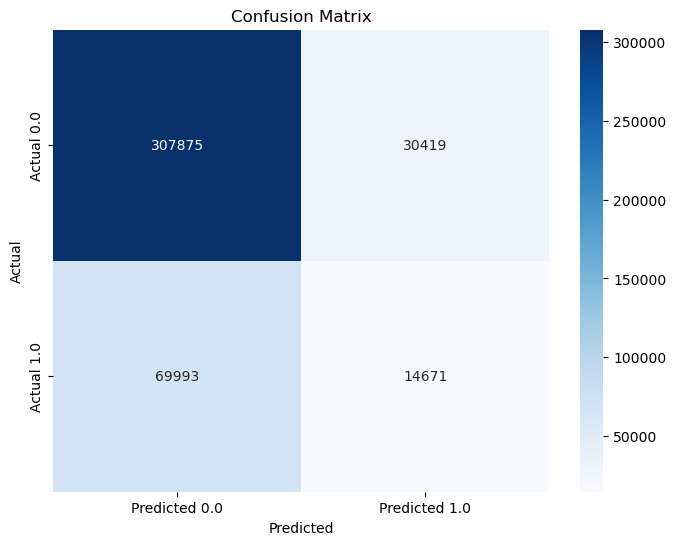

In [33]:
# Plotting with seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86    338294
         1.0       0.33      0.17      0.23     84664

    accuracy                           0.76    422958
   macro avg       0.57      0.54      0.54    422958
weighted avg       0.72      0.76      0.73    422958



In [35]:
print(f"F1 Score : {f1_score(y_test, y_pred)}")

F1 Score : 0.2261356104628759


# Investigating importance of different variables/features

In [36]:
# Extracting importances into series
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

In [37]:
# Look at top 20 features by importance
top_features = feature_importances.sort_values(ascending=False).head(20)
print(top_features)

flight_length_encoded      0.051211
dest_airport_20_OTHER      0.032272
Day_of_week_Monday         0.031635
Day_of_week_Thursday       0.031314
time_bin_05:00–09:00       0.029124
Day_of_week_Friday         0.028977
origin_airport_20_OTHER    0.028372
Day_of_week_Sunday         0.027893
Day_of_week_Wednesday      0.027551
Day_of_week_Tuesday        0.026401
Day_of_week_Saturday       0.026058
Month_7                    0.016366
Month_3                    0.015914
Month_5                    0.015848
Month_4                    0.015660
time_bin_09:00–13:00       0.015440
Year_2022                  0.014845
Month_8                    0.014572
time_bin_13:00–17:00       0.013602
Month_1                    0.013532
dtype: float64


In [38]:
# Fitting logistic regression to get better idea of direction of effects
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg.coef_[0] 
}).sort_values(by='coef')



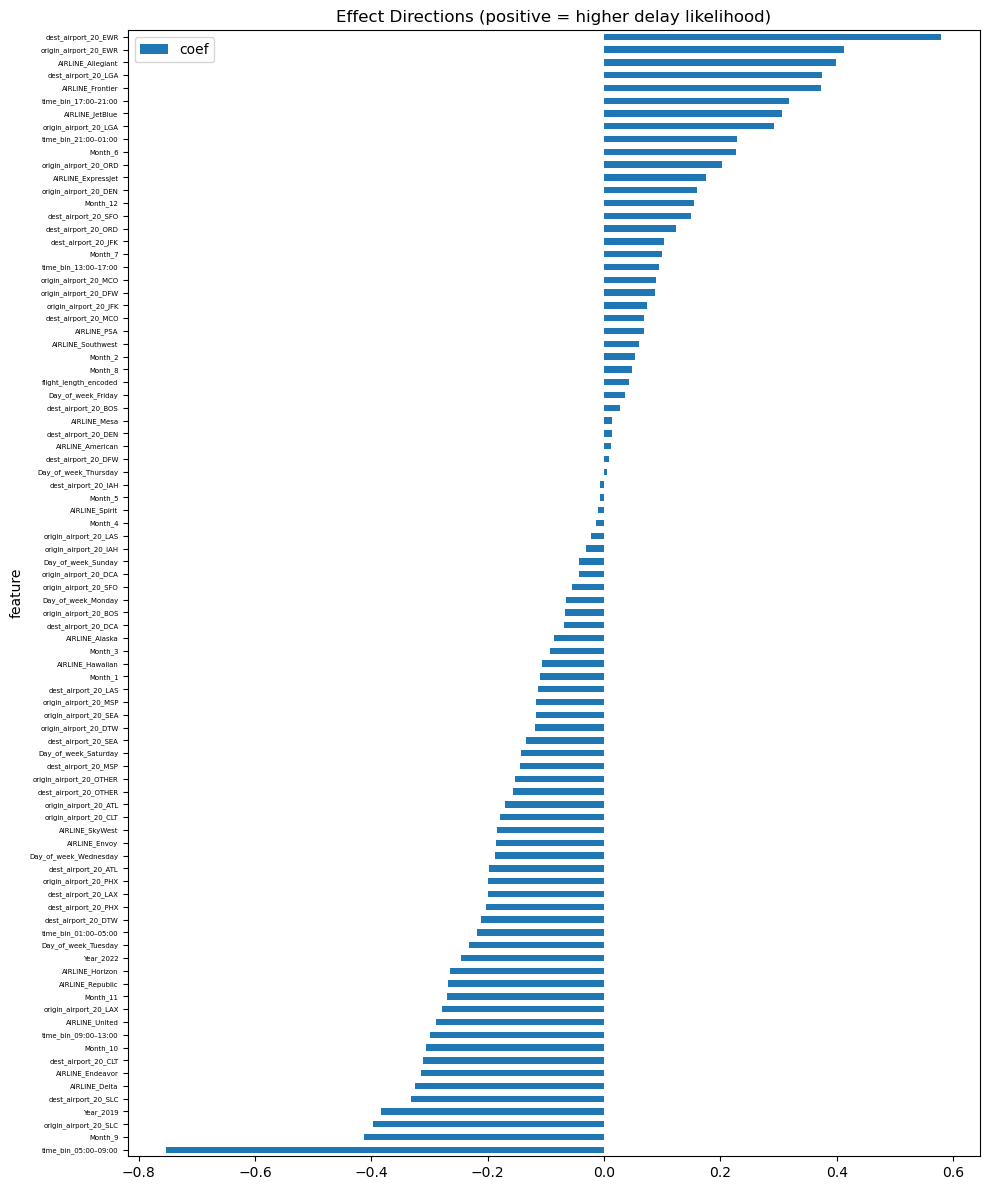

In [39]:
# Plotting coefficients with positive corresponding to higher probability of delay
ax = coef_df.set_index('feature').plot(kind='barh', 
                                  figsize=(10, 12), 
                                  title='Effect Directions (positive = higher delay likelihood)')
ax.tick_params(axis='y', labelsize=5, pad=3)

plt.tight_layout()
plt.show()

[Text(0.5, 0.9, 'time_bin_05:00–09:00 <= 0.5\ngini = 0.32\nsamples = 986899\nvalue = [789842, 197057]'),
 Text(0.25, 0.7, 'time_bin_09:00–13:00 <= 0.5\ngini = 0.349\nsamples = 757668\nvalue = [587089, 170579]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'AIRLINE_Delta <= 0.5\ngini = 0.376\nsamples = 516544\nvalue = [386674, 129870]'),
 Text(0.0625, 0.3, 'AIRLINE_SkyWest <= 0.5\ngini = 0.386\nsamples = 447409\nvalue = [330655.0, 116754.0]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'origin_airport_20_LGA <= 0.5\ngini = 0.307\nsamples = 69135\nvalue = [56019, 13116]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'dest_airport_20_EWR <= 0.5\ngini = 0.281\nsamples = 241124\nvalue = [200415, 40709]'),
 Text(0.3125, 0.3, 'AIRLINE_Delta <= 0.5\ngini = 0.277\nsamples = 236444\nvalue = [197096, 39348]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.

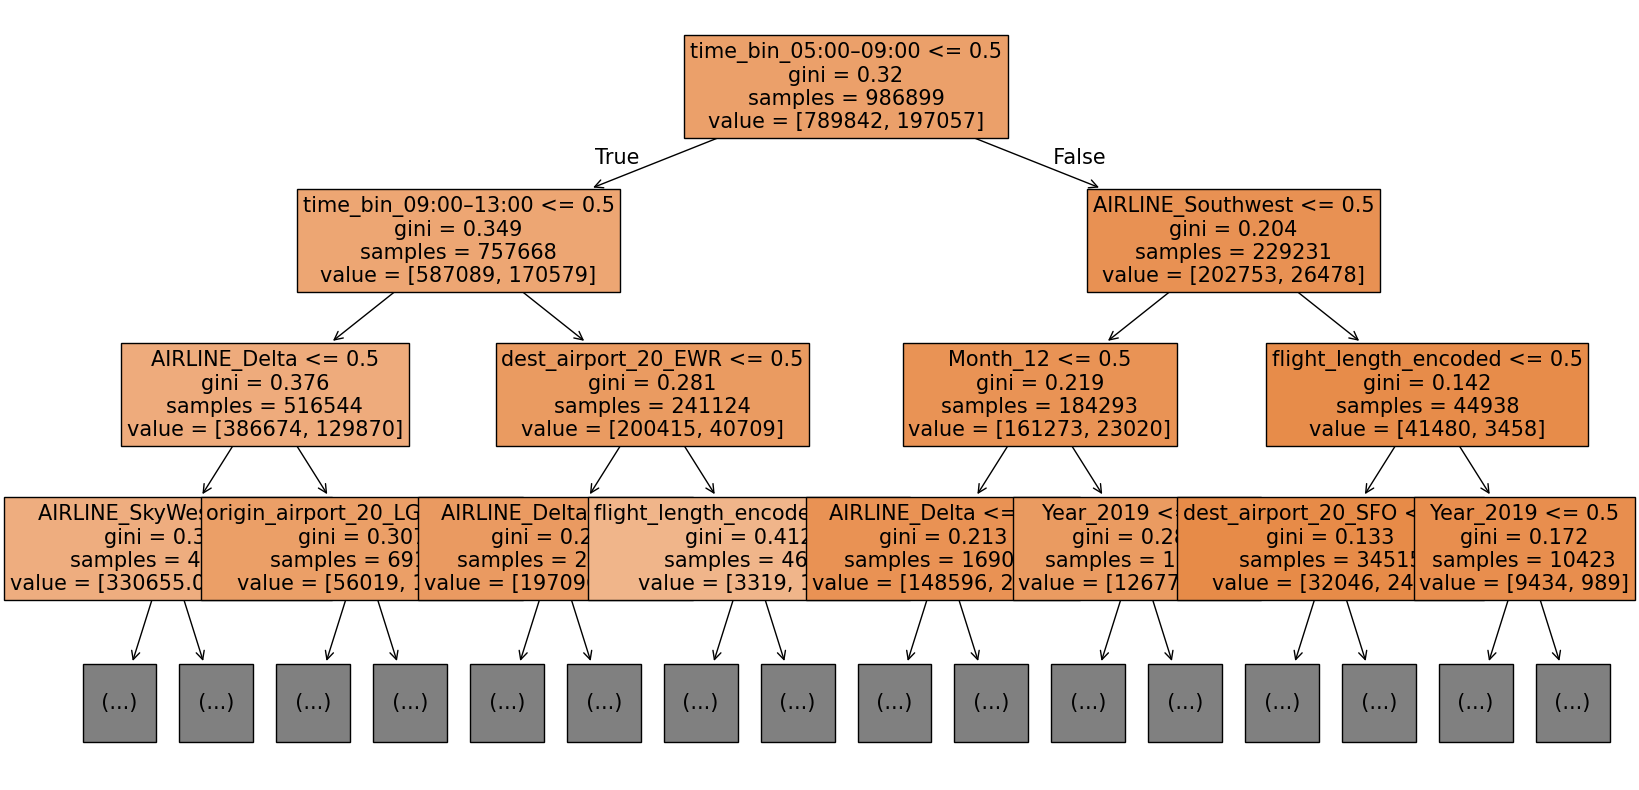

In [40]:
# Plotting tree with max depth at 4
plt.figure(figsize=(20, 10))
plot_tree(clf, 
          feature_names=X.columns, 
          max_depth=3, 
          filled=True,
          fontsize=15)

# 5. Fitting Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python following this heavily

In [52]:
rf = RandomForestClassifier(random_state=123,
                            class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=123)

In [53]:
y_pred = rf.predict(X_test)

In [54]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7014242548905565
Precision: 0.29802102239088446
Recall: 0.362680714353208


Visualise Results

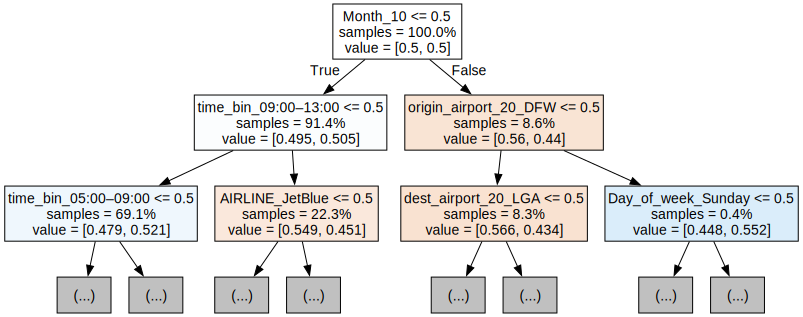

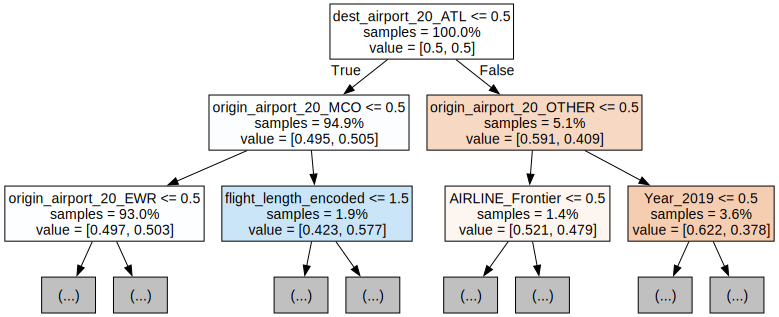

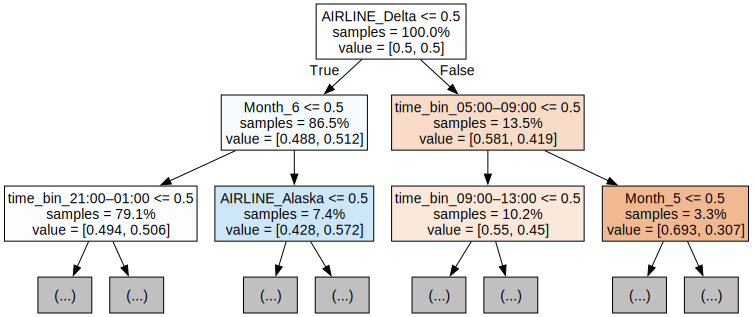

In [55]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Tuning hyperparameters

In [56]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20)    # starting at 3 to avoid underfitting
   }   

In [63]:
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 scoring='f1')

In [64]:
# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=123),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001791A650080>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001791A653A10>},
                   scoring='f1')

In [65]:
# Saving random search object to not have to do the long command in the future
import joblib

rand_s_path = os.path.join(path, 'Models', 'random_forest_randsearch.pkl')
joblib.dump(rand_search, rand_s_path)

['C:\\Users\\seank\\OneDrive\\Dokumente\\Career Foundry Data Analytics Course\\Data Immersion\\6\\Models\\random_forest_randsearch.pkl']

In [66]:
# Create variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 221}


In [67]:
# Predict outcomes again on test set, using model with best hyperparameters
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6225606324977894
Precision: 0.2892305962387204
Recall: 0.6076254370216385


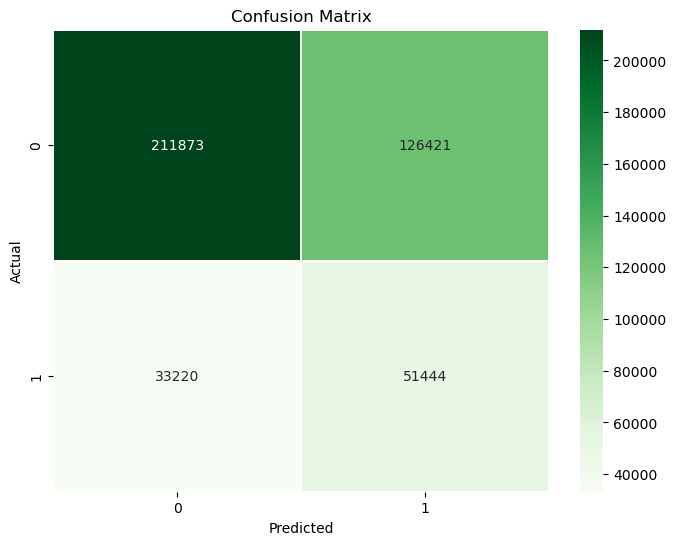

In [ ]:
# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)

# Plot with seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d',
            cmap='Greens', linewidths=0.2)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<Axes: >

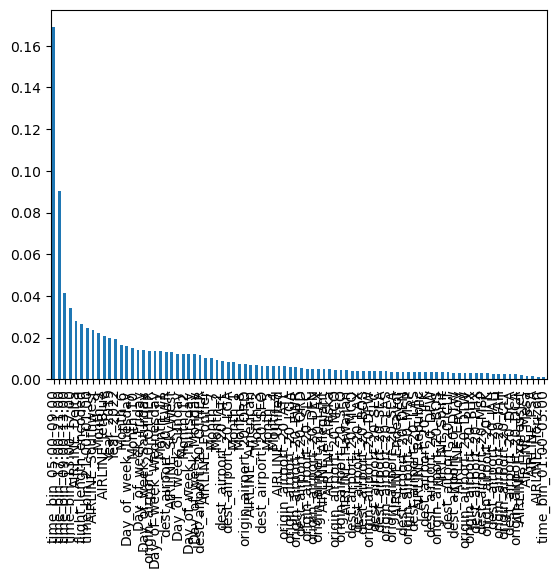

In [83]:
# Create series with feature importances from model and feature names from training data
feature_importances = (pd.Series(best_rf.feature_importances_, index=X_train.columns)
                       .sort_values(ascending=False))

# bar chart
feature_importances.plot.bar()

<Axes: >

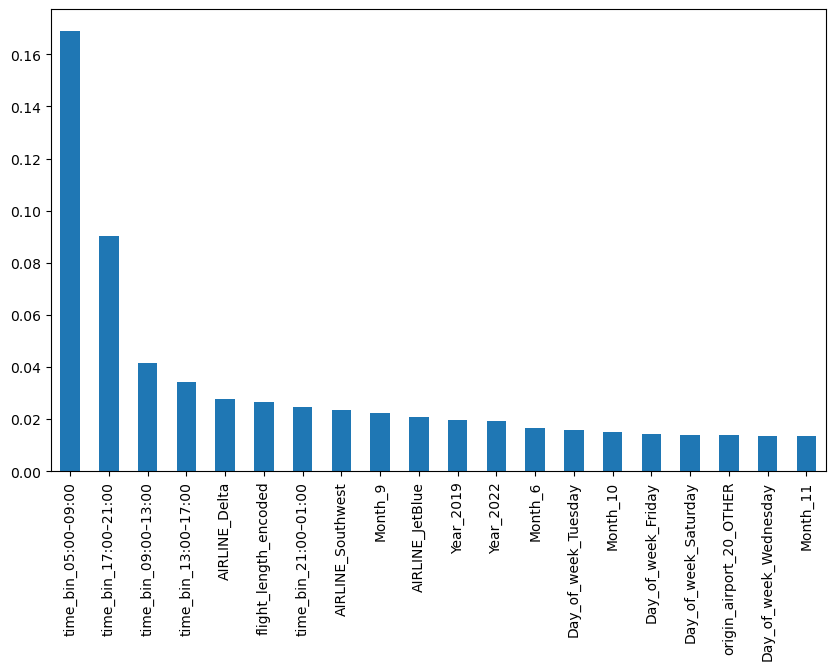

In [84]:
feature_importances.head(20).plot.bar(figsize=(10,6))

# 6. Predicting Marc's Flights
AF 2196 on 1 June 2025.

In [85]:
# Get columns for input
print(X.columns.tolist())

['flight_length_encoded', 'AIRLINE_Alaska', 'AIRLINE_Allegiant', 'AIRLINE_American', 'AIRLINE_Delta', 'AIRLINE_Endeavor', 'AIRLINE_Envoy', 'AIRLINE_ExpressJet', 'AIRLINE_Frontier', 'AIRLINE_Hawaiian', 'AIRLINE_Horizon', 'AIRLINE_JetBlue', 'AIRLINE_Mesa', 'AIRLINE_PSA', 'AIRLINE_Republic', 'AIRLINE_SkyWest', 'AIRLINE_Southwest', 'AIRLINE_Spirit', 'AIRLINE_United', 'origin_airport_20_ATL', 'origin_airport_20_BOS', 'origin_airport_20_CLT', 'origin_airport_20_DCA', 'origin_airport_20_DEN', 'origin_airport_20_DFW', 'origin_airport_20_DTW', 'origin_airport_20_EWR', 'origin_airport_20_IAH', 'origin_airport_20_JFK', 'origin_airport_20_LAS', 'origin_airport_20_LAX', 'origin_airport_20_LGA', 'origin_airport_20_MCO', 'origin_airport_20_MSP', 'origin_airport_20_ORD', 'origin_airport_20_OTHER', 'origin_airport_20_PHX', 'origin_airport_20_SEA', 'origin_airport_20_SFO', 'origin_airport_20_SLC', 'dest_airport_20_ATL', 'dest_airport_20_BOS', 'dest_airport_20_CLT', 'dest_airport_20_DCA', 'dest_airport_2

In [86]:
# checking distance
msp_dfw = df[(df['ORIGIN']=='MSP') & (df['DEST']=='DFW')]
msp_dfw.head(5)

,AIRLINE,ORIGIN,DEST,Month,Day_of_week,Year,time_bin,delay15,flight_length,origin_airport_20,dest_airport_20,flight_length_encoded
2216,SkyWest,MSP,DFW,8,Saturday,2019,13:00–17:00,1.0,Short Distance(<1000),MSP,DFW,0
14769,American,MSP,DFW,9,Tuesday,2019,05:00–09:00,0.0,Short Distance(<1000),MSP,DFW,0
22784,Delta,MSP,DFW,9,Thursday,2022,17:00–21:00,1.0,Short Distance(<1000),MSP,DFW,0
27610,American,MSP,DFW,7,Tuesday,2022,09:00–13:00,0.0,Short Distance(<1000),MSP,DFW,0
33155,American,MSP,DFW,12,Thursday,2022,17:00–21:00,0.0,Short Distance(<1000),MSP,DFW,0


Flight length is <1000 so encoded as 0

Taking 2022 as year since its the post covid year that I have

In [87]:
marc_data = {
    'flight_length_encoded': 0,
    'AIRLINE_Alaska': 0, 
    'AIRLINE_Allegiant': 0, 
    'AIRLINE_American': 0,
    'AIRLINE_Delta': 1, 
    'AIRLINE_Endeavor': 0, 
    'AIRLINE_Envoy': 0, 
    'AIRLINE_ExpressJet': 0, 
    'AIRLINE_Frontier': 0, 
    'AIRLINE_Hawaiian': 0, 
    'AIRLINE_Horizon': 0, 
    'AIRLINE_JetBlue': 0, 
    'AIRLINE_Mesa': 0, 
    'AIRLINE_PSA': 0, 
    'AIRLINE_Republic': 0, 
    'AIRLINE_SkyWest': 0, 
    'AIRLINE_Southwest': 0, 
    'AIRLINE_Spirit': 0, 
    'AIRLINE_United': 0, 
    'origin_airport_20_ATL': 0, 
    'origin_airport_20_BOS': 0, 
    'origin_airport_20_CLT': 0, 
    'origin_airport_20_DCA': 0, 
    'origin_airport_20_DEN': 0, 
    'origin_airport_20_DFW': 0, 
    'origin_airport_20_DTW': 0, 
    'origin_airport_20_EWR': 0, 
    'origin_airport_20_IAH': 0, 
    'origin_airport_20_JFK': 0, 
    'origin_airport_20_LAS': 0, 
    'origin_airport_20_LAX': 0, 
    'origin_airport_20_LGA': 0, 
    'origin_airport_20_MCO': 0, 
    'origin_airport_20_MSP': 1, 
    'origin_airport_20_ORD': 0, 
    'origin_airport_20_OTHER': 0, 
    'origin_airport_20_PHX': 0, 
    'origin_airport_20_SEA': 0, 
    'origin_airport_20_SFO': 0, 
    'origin_airport_20_SLC': 0, 
    'dest_airport_20_ATL': 0, 
    'dest_airport_20_BOS': 0, 
    'dest_airport_20_CLT': 0, 
    'dest_airport_20_DCA': 0, 
    'dest_airport_20_DEN': 0, 
    'dest_airport_20_DFW': 1, 
    'dest_airport_20_DTW': 0, 
    'dest_airport_20_EWR': 0, 
    'dest_airport_20_IAH': 0, 
    'dest_airport_20_JFK': 0,
    'dest_airport_20_LAS': 0, 
    'dest_airport_20_LAX': 0, 
    'dest_airport_20_LGA': 0, 
    'dest_airport_20_MCO': 0, 
    'dest_airport_20_MSP': 0, 
    'dest_airport_20_ORD': 0, 
    'dest_airport_20_OTHER': 0, 
    'dest_airport_20_PHX': 0, 
    'dest_airport_20_SEA': 0, 
    'dest_airport_20_SFO': 0, 
    'dest_airport_20_SLC': 0, 
    'Month_1': 0, 
    'Month_2': 0, 
    'Month_3': 0, 
    'Month_4': 0, 
    'Month_5': 0, 
    'Month_6': 1,
    'Month_7': 0, 
    'Month_8': 0, 
    'Month_9': 0, 
    'Month_10': 0, 
    'Month_11': 0, 
    'Month_12': 0, 
    'Day_of_week_Monday': 0, 
    'Day_of_week_Tuesday': 0, 
    'Day_of_week_Wednesday': 0, 
    'Day_of_week_Thursday': 0, 
    'Day_of_week_Friday': 0, 
    'Day_of_week_Saturday': 0, 
    'Day_of_week_Sunday': 1, 
    'Year_2019': 0, 
    'Year_2022': 1, 
    'time_bin_05:00–09:00': 0, 
    'time_bin_09:00–13:00': 0, 
    'time_bin_13:00–17:00': 1, 
    'time_bin_17:00–21:00': 0, 
    'time_bin_21:00–01:00': 0, 
    'time_bin_01:00–05:00': 0
}


In [88]:
# Create df
marc_input = pd.DataFrame([marc_data])

# Reorder columns to match X
marc_input = marc_input[X.columns]


In [89]:
# Predict
prediction = best_rf.predict(marc_input)
print("Prediction:", prediction)

Prediction: [0.]


In [90]:
# Get probabilities of classes
probabilities = best_rf.predict_proba(marc_input)
print("Class probabilities:", probabilities)

Class probabilities: [[0.52504092 0.47495908]]


Checking Return Flight. DL1041 on 06.06.25

In [91]:
# Verify Distance
dfw_dtw = df[(df['ORIGIN']=='DFW') & (df['DEST']=='DTW')]
dfw_dtw.head(5)

,AIRLINE,ORIGIN,DEST,Month,Day_of_week,Year,time_bin,delay15,flight_length,origin_airport_20,dest_airport_20,flight_length_encoded
2219,Delta,DFW,DTW,11,Sunday,2019,17:00–21:00,0.0,Short Distance(<1000),DFW,DTW,0
7318,American,DFW,DTW,12,Monday,2019,13:00–17:00,0.0,Short Distance(<1000),DFW,DTW,0
10171,American,DFW,DTW,7,Friday,2022,05:00–09:00,0.0,Short Distance(<1000),DFW,DTW,0
11376,Delta,DFW,DTW,7,Wednesday,2019,05:00–09:00,0.0,Short Distance(<1000),DFW,DTW,0
14078,Delta,DFW,DTW,4,Tuesday,2019,05:00–09:00,0.0,Short Distance(<1000),DFW,DTW,0


In [92]:
marc_data_return = {
    'flight_length_encoded': 0,
    'AIRLINE_Alaska': 0, 
    'AIRLINE_Allegiant': 0, 
    'AIRLINE_American': 0,
    'AIRLINE_Delta': 1, 
    'AIRLINE_Endeavor': 0, 
    'AIRLINE_Envoy': 0, 
    'AIRLINE_ExpressJet': 0, 
    'AIRLINE_Frontier': 0, 
    'AIRLINE_Hawaiian': 0, 
    'AIRLINE_Horizon': 0, 
    'AIRLINE_JetBlue': 0, 
    'AIRLINE_Mesa': 0, 
    'AIRLINE_PSA': 0, 
    'AIRLINE_Republic': 0, 
    'AIRLINE_SkyWest': 0, 
    'AIRLINE_Southwest': 0, 
    'AIRLINE_Spirit': 0, 
    'AIRLINE_United': 0, 
    'origin_airport_20_ATL': 0, 
    'origin_airport_20_BOS': 0, 
    'origin_airport_20_CLT': 0, 
    'origin_airport_20_DCA': 0, 
    'origin_airport_20_DEN': 0, 
    'origin_airport_20_DFW': 1, 
    'origin_airport_20_DTW': 0, 
    'origin_airport_20_EWR': 0, 
    'origin_airport_20_IAH': 0, 
    'origin_airport_20_JFK': 0, 
    'origin_airport_20_LAS': 0, 
    'origin_airport_20_LAX': 0, 
    'origin_airport_20_LGA': 0, 
    'origin_airport_20_MCO': 0, 
    'origin_airport_20_MSP': 0, 
    'origin_airport_20_ORD': 0, 
    'origin_airport_20_OTHER': 0, 
    'origin_airport_20_PHX': 0, 
    'origin_airport_20_SEA': 0, 
    'origin_airport_20_SFO': 0, 
    'origin_airport_20_SLC': 0, 
    'dest_airport_20_ATL': 0, 
    'dest_airport_20_BOS': 0, 
    'dest_airport_20_CLT': 0, 
    'dest_airport_20_DCA': 0, 
    'dest_airport_20_DEN': 0, 
    'dest_airport_20_DFW': 0, 
    'dest_airport_20_DTW': 1, 
    'dest_airport_20_EWR': 0, 
    'dest_airport_20_IAH': 0, 
    'dest_airport_20_JFK': 0,
    'dest_airport_20_LAS': 0, 
    'dest_airport_20_LAX': 0, 
    'dest_airport_20_LGA': 0, 
    'dest_airport_20_MCO': 0, 
    'dest_airport_20_MSP': 0, 
    'dest_airport_20_ORD': 0, 
    'dest_airport_20_OTHER': 0, 
    'dest_airport_20_PHX': 0, 
    'dest_airport_20_SEA': 0, 
    'dest_airport_20_SFO': 0, 
    'dest_airport_20_SLC': 0, 
    'Month_1': 0, 
    'Month_2': 0, 
    'Month_3': 0, 
    'Month_4': 0, 
    'Month_5': 0, 
    'Month_6': 1,
    'Month_7': 0, 
    'Month_8': 0, 
    'Month_9': 0, 
    'Month_10': 0, 
    'Month_11': 0, 
    'Month_12': 0, 
    'Day_of_week_Monday': 0, 
    'Day_of_week_Tuesday': 0, 
    'Day_of_week_Wednesday': 0, 
    'Day_of_week_Thursday': 0, 
    'Day_of_week_Friday': 1, 
    'Day_of_week_Saturday': 0, 
    'Day_of_week_Sunday': 0, 
    'Year_2019': 0, 
    'Year_2022': 1, 
    'time_bin_05:00–09:00': 0, 
    'time_bin_09:00–13:00': 0, 
    'time_bin_13:00–17:00': 1, 
    'time_bin_17:00–21:00': 0, 
    'time_bin_21:00–01:00': 0, 
    'time_bin_01:00–05:00': 0
}


In [93]:
# Create df
marc_return_input = pd.DataFrame([marc_data_return])

# Reorder columns to match X
marc_return_input = marc_return_input[X.columns]


In [94]:
# Predict
prediction = best_rf.predict(marc_return_input)
print("Prediction:", prediction)

Prediction: [0.]


In [95]:
# Get probabilities of classes
probabilities = best_rf.predict_proba(marc_return_input)
print("Class probabilities:", probabilities)

Class probabilities: [[0.50055231 0.49944769]]
